# Logistic Regression on the Cleaned Cardiovascular Dataset

In this section we build a **baseline logistic regression model** on our **cleaned** CVD dataset.

Logistic regression is the appropriate choice here because:
- Our target `cardio` is **binary** (0 = no cardiovascular disease, 1 = disease).
- Logistic regression models the **probability** of `cardio = 1` given the input features.
- It is a **linear, interpretable** model, so we can later inspect which features increase or decrease risk.

We will go through these steps:

1. Load the cleaned dataset from `../data/clean/cardio_cleaned.csv`.
2. Define features `X` and target `y`.
3. Split into training and test sets (with stratification).
4. Standardize the features (important for logistic regression).
5. Fit the logistic regression model.
6. Evaluate it with accuracy, ROC AUC, and a classification report.
7. Inspect model coefficients to understand feature effects.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

# 1. Load the cleaned dataset
clean_path = "../data/clean/cardio_cleaned.csv"
df = pd.read_csv(clean_path, sep=';')

print("Shape of cleaned dataset:", df.shape)
df.head()


Shape of cleaned dataset: (68562, 14)


,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI,pp
0,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,30
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,50
2,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,60
3,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,50
4,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,40


## Step 1 – Define Features (X) and Target (y)

Our target variable is:
- `cardio`: 0 (no CVD) or 1 (CVD)

All other columns are candidate features:
- Demographic: `age_years`, `gender`
- Anthropometrics: `height`, `weight`, `BMI`
- Blood pressure: `ap_hi`, `ap_lo`, `pp`, `bp_mean` (if present)
- Lab/clinical: `cholesterol`, `gluc`
- Lifestyle: `smoke`, `alco`, `active`

The cleaned dataset is already numeric, so we can use it directly without one-hot encoding for now.  
This keeps the model simple and lets us see basic linear relationships.


In [4]:
# 2. Define X and y
y = df['cardio']
X = df.drop(columns=['cardio'])

print("Features:", list(X.columns))
print("Target distribution:\n", y.value_counts(normalize=True))

Features: ['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'BMI', 'pp']
Target distribution:
 cardio
0    0.504901
1    0.495099
Name: proportion, dtype: float64


## Step 2 – Train/Test Split (With Stratification)

We split the data into:
- **Training set**: used to fit the model
- **Test set**: used to evaluate generalization performance

We use:
- `test_size=0.2`: 20% of data for testing
- `random_state=42`: to make the split reproducible
- `stratify=y`: to keep the same proportion of `cardio=0` and `cardio=1` in train and test

Stratification is important for medical data so that both sets reflect the original class balance.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

Train shape: (54849, 13)
Test shape: (13713, 13)
Train target distribution:
 cardio
0    0.504895
1    0.495105
Name: proportion, dtype: float64
Test target distribution:
 cardio
0    0.504922
1    0.495078
Name: proportion, dtype: float64


## Step 3 – Feature Scaling (Standardization)

Logistic regression is a linear model that is sensitive to the **scale** of the features.

If features are on very different scales (e.g., `age_years` ~ 30–70, `ap_hi` ~ 90–200, `BMI` ~ 15–60), then:
- The optimization algorithm can converge more slowly.
- Coefficients become harder to compare.
- Regularization (if used) does not work uniformly.

We apply **standardization**:
- Each feature is transformed to have mean 0 and standard deviation 1.
- We fit the scaler *only* on the training data, then apply it to both train and test.

This avoids data leakage from the test set.

In [6]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  # fit on train, transform train
X_test_scaled = scaler.transform(X_test)        # transform test with same parameters

print("Scaled train shape:", X_train_scaled.shape)
print("Scaled test shape:", X_test_scaled.shape)

Scaled train shape: (54849, 13)
Scaled test shape: (13713, 13)


## Step 4 – Train Logistic Regression Model

We now train a **logistic regression classifier**.

Key settings:
- `max_iter=1000`: increase the maximum number of iterations to ensure convergence.
- We use the default `penalty='l2'` and `solver='lbfgs'`, which are standard for this type of problem.

The model will learn coefficients β for each feature such that:

\[
P(\text{cardio}=1 \mid X) = \sigma(\beta_0 + \beta_1 x_1 + \dots + \beta_k x_k)
\]

where σ is the sigmoid function.


In [7]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

print("Model fitted.")

Model fitted.


## Step 5 – Evaluate the Model (Accuracy, ROC AUC, Classification Report)

We evaluate our model on the **test set** using:

- **Accuracy**: proportion of correct predictions.
- **ROC AUC**: area under the ROC curve; measures ranking quality of predicted probabilities.
- **Classification report**: precision, recall, F1-score per class.
- **Confusion matrix**: counts of TP, TN, FP, FN.

For medical problems, accuracy alone is not enough; we also pay attention to recall for the positive class (cardio = 1).


Accuracy: 0.7266827098373806
ROC AUC: 0.795001018570922

Classification report:

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6924
           1       0.75      0.67      0.71      6789

    accuracy                           0.73     13713
   macro avg       0.73      0.73      0.73     13713
weighted avg       0.73      0.73      0.73     13713

Confusion matrix:
 [[5422 1502]
 [2246 4543]]


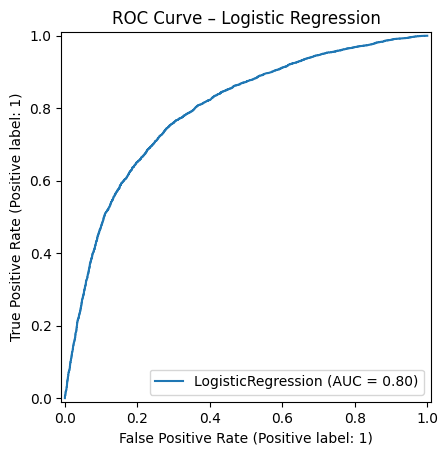

In [8]:
# Predict class labels and probabilities
y_pred = logreg.predict(X_test_scaled)
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", acc)
print("ROC AUC:", roc)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# ROC curve
RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test)
plt.title("ROC Curve – Logistic Regression")
plt.show()


## Step 6 – Interpret Logistic Regression Coefficients

One of the advantages of logistic regression is interpretability.

Each coefficient βᵢ corresponds to a feature and tells us:

- If βᵢ > 0: Increasing this feature (while others fixed) **increases** the log-odds of `cardio = 1`.
- If βᵢ < 0: Increasing this feature **decreases** the log-odds of `cardio = 1`.
- The magnitude |βᵢ| indicates how strong the effect is (in the linear approximation).

Because we scaled the features, the coefficients are on a comparable scale,  
so features with larger |βᵢ| have a stronger influence on the prediction.


In [9]:
# Extract feature names and coefficients
coef = logreg.coef_[0]  # single row for binary classification

coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': coef
})

# Sort by absolute effect
coef_df['abs_coeff'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coeff', ascending=False)

coef_df


,feature,coefficient,abs_coeff
3,ap_hi,0.449986,0.449986
4,ap_lo,0.373933,0.373933
10,age_years,0.341411,0.341411
12,pp,0.341251,0.341251
5,cholesterol,0.338908,0.338908
9,active,-0.088276,0.088276
2,weight,0.080031,0.080031
11,BMI,0.073371,0.073371
6,gluc,-0.064522,0.064522
8,alco,-0.045464,0.045464


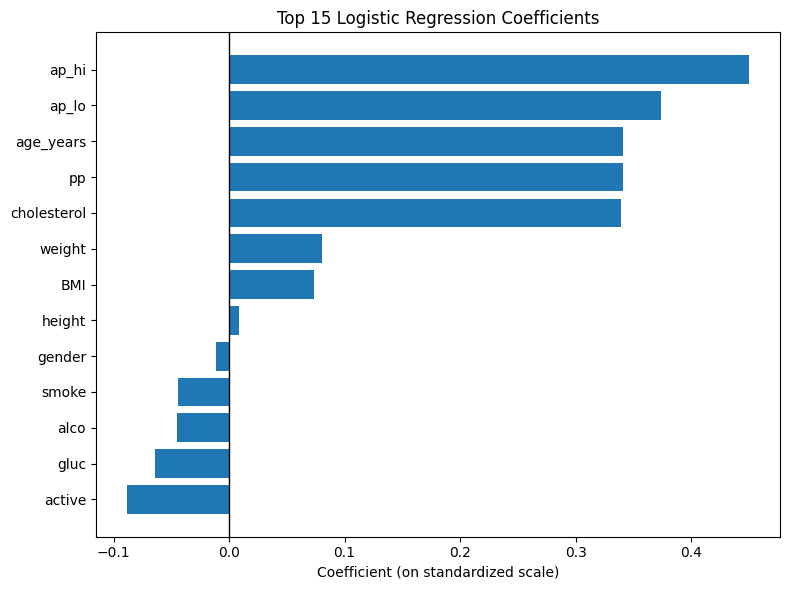

In [10]:
# Optional: quick bar plot of top 15 features by absolute coefficient
top_n = 15
top_coef = coef_df.head(top_n).sort_values('coefficient')

plt.figure(figsize=(8, 6))
plt.barh(top_coef['feature'], top_coef['coefficient'])
plt.axvline(0, color='black', linewidth=1)
plt.title(f"Top {top_n} Logistic Regression Coefficients")
plt.xlabel("Coefficient (on standardized scale)")
plt.tight_layout()
plt.show()


## Summary of Logistic Regression Step

At this point we have:

1. Loaded the **cleaned cardiovascular dataset**.
2. Defined features and target.
3. Performed a **stratified train/test split**.
4. Standardized the features using `StandardScaler`.
5. Trained a **logistic regression classifier**.
6. Evaluated it with accuracy, ROC AUC, classification report, and confusion matrix.
7. Inspected feature coefficients to see which variables push the model toward predicting cardiovascular disease.

Next steps can include:
- Comparing this baseline to a **Decision Tree** or **Random Forest**.
- Doing **feature engineering** (e.g., interaction terms or non-linear transformations).
- Performing **hyperparameter tuning** (e.g., regularization strength `C`).
